In [1]:
# basic python packages
import numpy as np
import pandas as pd
import os
import sys 

# plotting
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# singlecell packages
import scanpy as sc
import anndata
import scrublet
import harmonypy as hm

# other single cell packages
import muon as mu # multi-modal anndatas
import celltypist # automated label predictions
import scirpy # immune cell repertoire analysis
import cellanova as cnova
import gseapy as gp

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load BigSur
bigsur_dir = '/home/groups/singlecell/smorabito/bin/BigSur/'
sys.path.append(bigsur_dir) 

from BigSur.feature_selection import mcfano_feature_selection as mcfano

In [17]:
# helper func
def append_percent_expressed(adata, marker_genes_df, group_key, expression_thresh):
    """
    Append percentage of cells expressing each gene in the cluster of interest
    (pct_in_group) and in all other clusters (pct_out_group) to the marker gene DataFrame.

    Parameters:
    - adata: AnnData object.
    - marker_genes_df: DataFrame of marker genes generated by sc.tl.rank_genes_groups.
    - group_key: Column in adata.obs containing cluster annotations (e.g., 'leiden').

    Returns:
    - Updated marker gene DataFrame with pct_in_group and pct_out_group columns.
    """
    # Binary matrix indicating whether each gene is expressed in each cell
    binary_matrix = adata.X > expression_thresh  # Adjust if data is log-transformed or sparse
    
    # Initialize new columns
    pct_in_group_list = []
    pct_out_group_list = []

    # Iterate over each cluster in the marker gene DataFrame
    unique_clusters = marker_genes_df["group"].unique()
    for cluster in unique_clusters:
        print(cluster)
        # Create a mask for the cluster of interest
        cluster_mask = adata.obs[group_key] == cluster

        # Calculate percentages
        pct_in_group = np.asarray(binary_matrix[cluster_mask, :].mean(axis=0)).flatten() * 100
        pct_out_group = np.asarray(binary_matrix[~cluster_mask, :].mean(axis=0)).flatten() * 100

        # Map percentages back to marker genes
        for gene in marker_genes_df[marker_genes_df["group"] == cluster]["names"]:
            gene_idx = adata.var_names.get_loc(gene)
            pct_in_group_list.append(pct_in_group[gene_idx])
            pct_out_group_list.append(pct_out_group[gene_idx])

    # Add the calculated percentages to the DataFrame
    marker_genes_df["pct_in_group"] = pct_in_group_list
    marker_genes_df["pct_out_group"] = pct_out_group_list

    return marker_genes_df



In [4]:
# set the project directory 
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/clustering/testing')
data_dir = 'data/'
fig_dir = 'figures/'

In [5]:
# load the SERPENTINE dataset 
adata_met = sc.read_h5ad(
    '/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_PCA_27-11-24_annotated.h5ad'
)

In [6]:
# load the Chen et al dataset
adata_pri = sc.read_h5ad(
    '/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/Chen2024_Tumor_processed_201124.h5ad'
)

## align the meta-data for the two 

TODO: Make this into its own Notebook!!!

Will need to do this more carefully later but just to test the integration I will only use the most necessary columns

* Patient
* MSS / MSI status

In [7]:
# rename columns in the primary tumor dataset:
new_cols = {
    'Ident' : 'Replicate',
    'MajorCellType': 'cell_type',
    'SubCellType' : 'orig_annotation',
    'Treatment' : 'Timepoint'
}

adata_pri.obs = adata_pri.obs.rename(columns=new_cols)


In [8]:
# fix the timepoint in the primary tumor dataset
adata_pri.obs.Timepoint.replace(
    {'I': 1, 'II':2, 'III':3, 'IV':4},
    inplace=True
)

In [9]:
# fix the Tissue name in the SERPENTINE dataset 
adata_met.obs.Tissue.value_counts()

Tissue
Liver met                                 161299
Lung met                                   71840
Peritoneum (right iliac fossa)             15291
Lymphnode (iliac)                          14344
Lymphnode (right axilary)                  13041
Peritoneal implant (right iliac fossa)      6828
Subcutaneous tissue �nodul�                 4757
Implant (nodul) pre-sacro                   3474
Lymphnode (hepatic iliar)                   1409
Name: count, dtype: int64

In [10]:
# fix the timepoint in the primary tumor dataset
adata_met.obs.Tissue.replace(
    {
        'Lymphnode (right axilary)': 'Lymph node',
        'Lymphnode (iliac)': 'Lymph node',
        'Lymphnode (hepatic iliar)': 'Lymph node',
        'Peritoneum (right iliac fossa)': 'Peritoneum',
        'Peritoneal implant (right iliac fossa)': 'Peritoneum'
    },
    inplace=True
)

In [12]:
# common columns:
columns_keep = list(set(adata_pri.obs.columns.to_list()) & set(adata_met.obs.columns.to_list()))
columns_keep = adata_met.obs.columns[adata_met.obs.columns.isin(columns_keep)].to_list()

In [13]:
# subset metadata by common columns:
adata_pri.obs = adata_pri.obs[columns_keep]
adata_met.obs = adata_met.obs[columns_keep]

In [14]:

# add the original annotations (from Gerard for SERPENTINE, and from Chen et al
adata_met.obs['bc'] = [x.split('-')[0] for x in adata_met.obs.index.to_list()]

# load the annotations
anno_df = pd.read_table('/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SP_annotations.csv', sep=',')
anno_df = anno_df.rename({'Unnamed: 0': 'barcode'}, axis=1)
anno_df['bc'] = [x.split('_')[-1] for x in anno_df.barcode.to_list()]
anno_df['bc_sample'] = anno_df['sample'].astype(str) + '-' + anno_df.bc.astype(str)

adata_met.obs['bc_sample'] = adata_met.obs.Replicate.astype(str) + '-' + adata_met.obs.bc.astype(str)
temp = adata_met.obs.merge(anno_df, how='left', on = 'bc_sample')
adata_met.obs['orig_annotation'] = temp['Annotation_2.0'].to_list()


In [15]:
# subset by celltype of interest 
cur_name = 'Tcells'

adata_pri = adata_pri[adata_pri.obs.cell_type.isin(['T', 'ILC'])].copy()
adata_met = adata_met[adata_met.obs.cell_type.isin(['T cells', 'NK cells'])].copy()

In [16]:
# fix the gene ids before merging
adata_met.var.gene_ids = adata_met.var.index.to_list()

In [17]:
# merge
adata = adata_pri.concatenate(adata_met) 
adata.shape

(298073, 36017)

In [18]:
adata = adata[adata.obs.pct_counts_mt <= 5].copy()
adata.shape

(280125, 36017)

## Run feature selection

Running the Feature Selection (BigSur) separately by Tissue + Timepoint.

* Primary Tumor
* Liver met
* Lung met
* Lymph node
* Other (includes the peritoneum & subcutaneous nodules, putting them together since they don't make up very much of the results. Maybe don't even include these ones?)

We will run enrichment analysis (`enrichR` via `gseapy`) to identify pathways which may be enriched in genes that are specific to a particular tissue.



In [25]:
adata.obs['Tissue_Timepoint'] = adata.obs.Tissue.astype(str) + "_" + adata.obs.Timepoint.astype(str)

In [27]:
adata.obs.Tissue_Timepoint.value_counts()

Tissue_Timepoint
Tumor_2                          45231
Tumor_1                          44592
Liver met_1                      41899
Liver met_2                      41211
Tumor_3                          28209
Lung met_2                       24661
Lung met_1                       18891
Lymph node_1                     12987
Liver met_3                       9280
Tumor_4                           5334
Peritoneum_2                      2531
Implant (nodul) pre-sacro_1       1697
Lymph node_2                      1680
Peritoneum_1                      1182
Subcutaneous tissue �nodul�_1      740
Name: count, dtype: int64

In [29]:
group_col = 'Tissue_Timepoint'

group_list = adata.obs[group_col].unique()
var_dict = {}

for cur_group in group_list:
    print(cur_group)
    cur_adata = adata[adata.obs[group_col] == cur_group].copy()

    sc.pp.filter_genes(cur_adata, min_cells=3)
    mcfano(cur_adata, layer='counts')

    var_dict[cur_group] = cur_adata.var.copy()
    

Tumor_1
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.6
Tumor_2
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Tumor_3
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Tumor_4
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.5
Liver met_1
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.6
Liver met_2
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Lung met_1
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Lung met_2
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.

In [35]:
var_dict['Lymph node_1'].head()

gene_ids    feature_types     mt  n_cells_by_counts-0  \
AL627309.1  AL627309.1  Gene Expression  False                  126   
AL627309.5  AL627309.5  Gene Expression  False                 1666   
LINC01409    LINC01409  Gene Expression  False                 2722   
FAM87B          FAM87B  Gene Expression  False                  157   
LINC01128    LINC01128  Gene Expression  False                16523   

            mean_counts-0  pct_dropout_by_counts-0  total_counts-0  \
AL627309.1       0.000454                99.954982           127.0   
AL627309.5       0.006081                99.404758          1702.0   
LINC01409        0.010090                99.027461          2824.0   
FAM87B           0.000568                99.943906           159.0   
LINC01128        0.065062                94.096525         18210.0   

            highly_variable-0   means-0  dispersions-0  ...   means-1  \
AL627309.1              False  0.001352       1.636611  ...  0.001855   
AL627309.5              False  0.019348       1.574453  ...  0.003284   
LINC01409               False  0.031738       1.594918  ...  0.046102   
FAM87B                  False  0.001564       1.514044  ...  0.000445   
LINC01128               False  0.164337       1.487450  ...  0.056974   

            dispersions-1  dispersions_norm-1  highly_variable_nbatches-1  \
AL627309.1      -0.027868           -0.159345                           0   
AL627309.5       0.013073           -0.087798                           0   
LINC01409        0.215034            0.256838                           9   
FAM87B          -0.254557           -0.596607                           0   
LINC01128        0.154346            0.157259                           5   

            highly_variable_intersection-1  n_cells   mc_Fano  FDR_adj_pvalue  \
AL627309.1                           False       14  1.134615        0.573191   
AL627309.5                           False       11  0.898717        0.763672   
LINC01409                            False      744  1.087390        0.091184   
FAM87B                               False        8  1.009210        0.689092   
LINC01128                            False      995  1.075161        0.095620   

             p_value  highly_variable  
AL627309.1  0.309927            False  
AL627309.5  0.590858            False  
LINC01409   0.024421            False  
FAM87B      0.457290            False  
LINC01128   0.025951            False  

[5 rows x 26 columns]

In [66]:
# count how many times each gene appears 
signif_list = []
for cur_group, cur_var in var_dict.items():
    print(cur_group)
    mc_cutoff = np.quantile(cur_var['mc_Fano'], q=0.9)
    tmp = cur_var.loc[(cur_var.p_value <= p_cutoff) & (cur_var.mc_Fano >= mc_cutoff)]
    tmp['group'] = cur_group 
    signif_list.append(tmp)
    print(tmp.shape)

# Exclude the genes that were only considered highly variable in 2 or fewer groups
combined = pd.concat(signif_list)
var_genes = combined.gene_ids.value_counts()[combined.gene_ids.value_counts() > 2].index.to_list()
adata.var['highly_variable'] = adata.var.index.isin(var_genes)


Tumor_1
(1370, 27)
Tumor_2
(1491, 27)
Tumor_3
(1377, 27)
Tumor_4
(1059, 27)
Liver met_1
(1942, 27)
Liver met_2
(1993, 27)
Lung met_1
(1732, 27)
Lung met_2
(1963, 27)
Liver met_3
(1751, 27)
Subcutaneous tissue �nodul�_1
(690, 27)
Implant (nodul) pre-sacro_1
(1032, 27)
Peritoneum_1
(759, 27)
Lymph node_1
(1876, 27)
Peritoneum_2
(1181, 27)
Lymph node_2
(1020, 27)


/scratch_tmp/33192744/ipykernel_220693/1209175104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['group'] = cur_group
/scratch_tmp/33192744/ipykernel_220693/1209175104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['group'] = cur_group
/scratch_tmp/33192744/ipykernel_220693/1209175104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [67]:
len(var_genes)

2181

In [68]:
# save the unprocessed object
adata.write_h5ad('{}merged_{}_unprocessed_CellANOVA.h5ad'.format(data_dir, cur_name))


... storing 'dataset' as categorical
... storing 'bc' as categorical
... storing 'bc_sample' as categorical
... storing 'orig_annotation' as categorical
... storing 'Tissue_Timepoint' as categorical


## Integration w/ CellANOVA

Should we use one pool of controls, or use a separate pool of controls for each tissue? Another option, we can use one pool for our data vs the other dataset.


Also want to test this pipeline just on the Liver mets!!



I should try to run it using their pre-processing (but I want to use my own HVGs from BigSur). CellANOVA has this function `cnova.model.preprocess_data`, and I will try to follow their code as closely as possible from their source code but using my own HVGs from BigSur.


In [112]:
# re-load dataset
cur_name = 'Tcells'
adata = sc.read_h5ad('{}merged_{}_unprocessed_CellANOVA.h5ad'.format(data_dir, cur_name))

# reset the X to the log-normalized counts
adata.X = adata.layers['counts'].copy()

# remove genes with very few counts:
sc.pp.filter_genes(adata, min_cells=10)
adata.shape

# re-order (IDK if this has any effect on the downstream result, but they do it in the CellANOVA code so...)
integrate_key = "Replicate"
adata = adata[adata.obs.sort_values(integrate_key).index]

In [113]:
# normalize expression matrix
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()

# subset by HVGs
adata = adata[:,adata.var.highly_variable].copy()

# scale expression matrix
sc.pp.scale(adata)
adata.layers['scale'] = adata.X.copy()

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [114]:
group_col = 'Tissue'
group_list = adata.obs[group_col].unique()

control_dict = {
    group : adata.obs[
        (adata.obs[group_col] == group) & 
        (adata.obs.Timepoint == 1)
    ].Replicate.unique().to_list() for group in group_list 
}

# exclude the CD45 negative samples, and exclude the groups w/ only 1 control 
for group in group_list:
    value = control_dict[group]
    control_dict[group] = [v for v in value if "CD45neg" not in v]
    if len(control_dict[group]) == 1: del control_dict[group]
    

In [115]:
adata.shape

(280125, 2181)

In [116]:
# CellANOVA Step 1: Calculate "Main Effects"
# Guessing that this takes way longer if you use all genes? 
adata = cnova.model.calc_ME(
    adata,
    integrate_key='Replicate',
    k_harmony = 30
)


2024-12-16 16:24:07,572 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-12-16 16:24:39,381 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-12-16 16:24:42,105 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2024-12-16 16:27:36,872 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2024-12-16 16:30:35,931 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2024-12-16 16:33:35,605 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2024-12-16 16:36:34,665 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2024-12-16 16:38:41,245 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2024-12-16 16:40:21,772 - harmonypy - INFO - Iteration 7 of 30
Iteration 7 of 30
2024-12-16 16:42:02,041 - harmonypy - INFO - Iteration 8 of 30
Iteration 8 of 30
2024-12-16 16:43:36,038 - harmonypy - INFO - Iteration 9 of 30
Iteration 9 of 30

In [117]:
# CellANOVA Step 2: Calculate Batch Effects (BE)
adata = cnova.model.calc_BE(
    adata,
    integrate_key = 'Replicate',
    control_dict = control_dict
)

In [118]:
# CellANOVA Step 3: Calculate Treatment Effect (TE)
adata = cnova.model.calc_TE(
    adata, 
    integrate_key='Replicate'
)

In [ ]:
# Can I visualize (UMAP or ...?) the C, M, and T matrices?

In [121]:
adata.obsm

AxisArrays with keys: AIFI_L1, AIFI_L2, AIFI_L3, Immune_All_High, Immune_All_Low, X_pca, X_umap, Cmat

## Clustering using the CellANOVA integrated dataset

In [122]:
adata.layers['denoised'].shape

(280125, 2181)

In [123]:
# this is from the CellANOVA tutorial
integrated = anndata.AnnData(adata.layers['denoised'], dtype=np.float32)
integrated.obs = adata.obs.copy()
integrated.var_names = adata.var_names

In [124]:
# neighbors
#
# Q: Do I really run this on the denoised expression matrix, or does this run PCA again?
# Should check the paper I think. Also, in the above step should I include more genes or just HVGs?
sc.pp.neighbors(
    integrated,
    n_neighbors=20, n_pcs=30, metric='cosine'
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [125]:
sc.tl.umap(integrated, min_dist=0.35)

In [48]:

# clustering
res_list = [3]
for res in res_list:
    print(res)
    sc.tl.leiden(integrated, resolution=res)
    integrated.obs["leiden_{}".format(str(res))] = integrated.obs.leiden.to_list()



3


In [59]:
adata.obs['leiden_1'] = integrated.obs.leiden_1
adata.obs['leiden_3'] = integrated.obs.leiden_3


## save the results

Here we save the results and we add the integrated clusters & matrix to the original anndata.

In [ ]:
# save the results
integrated.write('{}{}_CellANOVA_16-12-24_processed_tissue.h5ad'.format(data_dir, cur_name))

In [ ]:
# save the results
adata.write('{}{}_CellANOVA_16-12-24_processed_tissue_full.h5ad'.format(data_dir, cur_name))

In [24]:
# re-load dataset
cur_name = 'Tcells'
adata = sc.read_h5ad('{}merged_{}_unprocessed_CellANOVA.h5ad'.format(data_dir, cur_name))

# remove genes with very few counts:
sc.pp.filter_genes(adata, min_cells=10)
adata.shape

# re-order (IDK if this has any effect on the downstream result, but they do it in the CellANOVA code so...)
integrate_key = "Replicate"
adata_full = adata[adata.obs.sort_values(integrate_key).index].copy()

# re-load the integrated dataset
integrated = sc.read_h5ad('{}{}_CellANOVA_16-12-24_processed_tissue.h5ad'.format(data_dir, cur_name))
adata = sc.read_h5ad('{}{}_CellANOVA_16-12-24_processed_tissue_full.h5ad'.format(data_dir, cur_name))

adata_full.obs['leiden'] = integrated.obs.leiden
adata_full.obsm['X_umap'] = integrated.obsm['X_umap']
adata_full.obsm['X_pca'] = integrated.obsm['X_pca']

# save the final object
adata_full.write_h5ad('{}{}_CellANOVA_16-12-24_final.h5ad'.format(data_dir, cur_name))

## Plotting the cluster results

In [ ]:
# re-load the anndata
cur_name = 'Tcells'
adata = sc.read_h5ad('{}{}_CellANOVA_16-12-24_final.h5ad'.format(data_dir, cur_name))


... storing 'leiden_3' as categorical
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


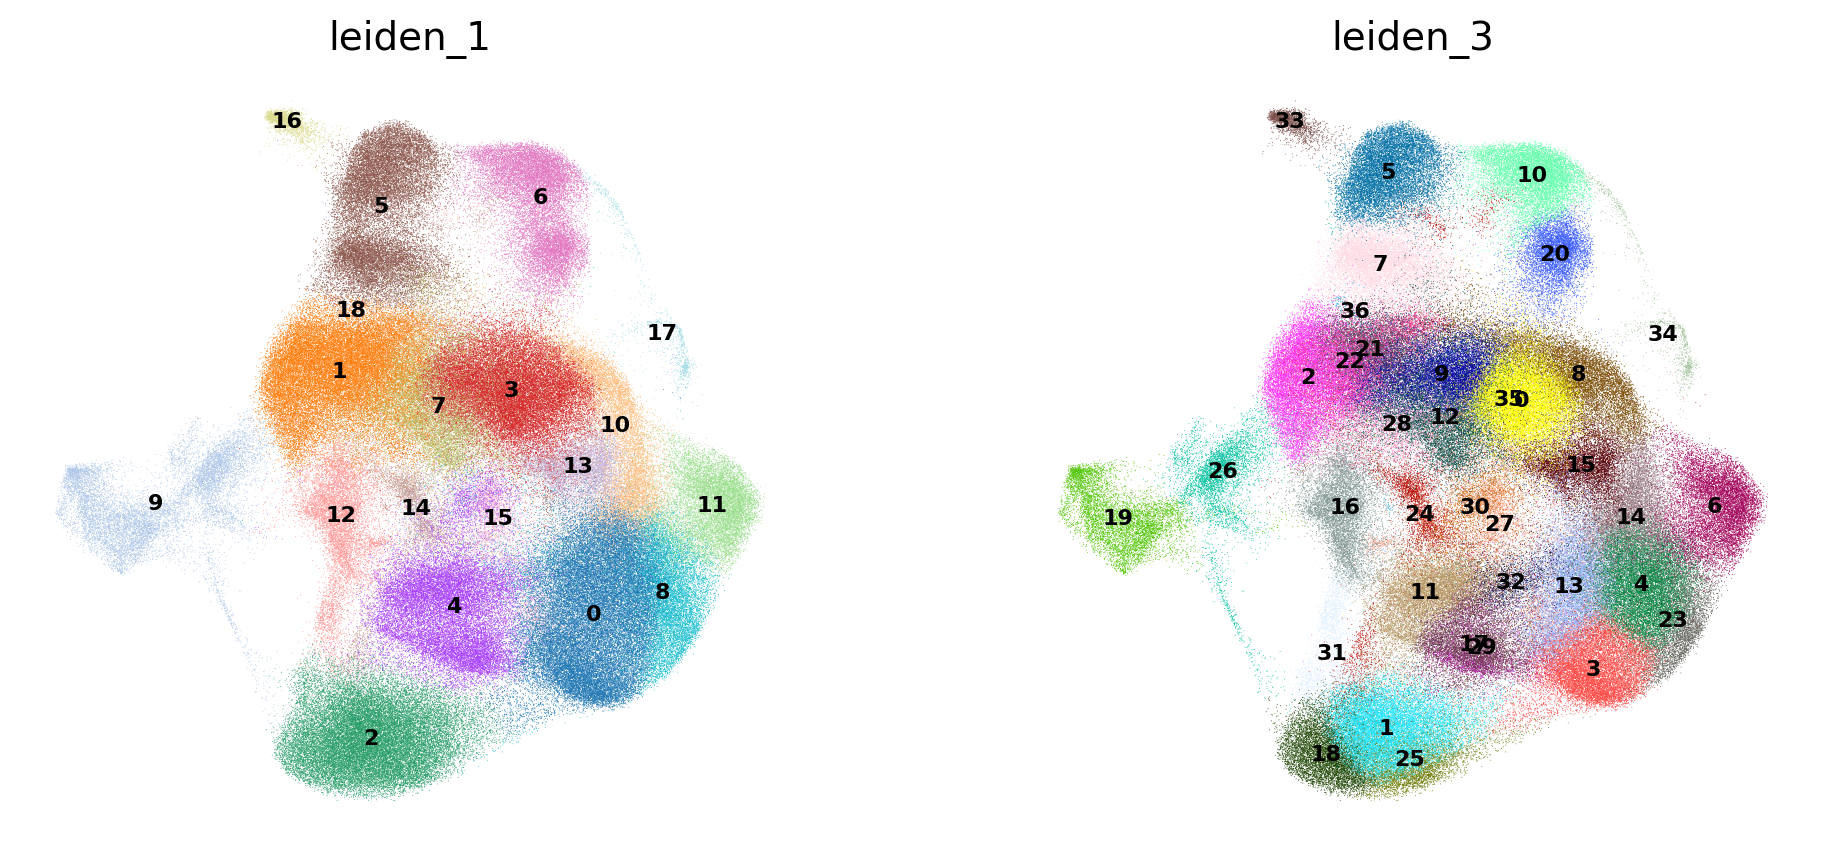

In [60]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata,
    color = ['leiden_1', 'leiden_3'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    ncols=2
)

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata,
    color = ['leiden', 'dataset'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    ncols=2
)

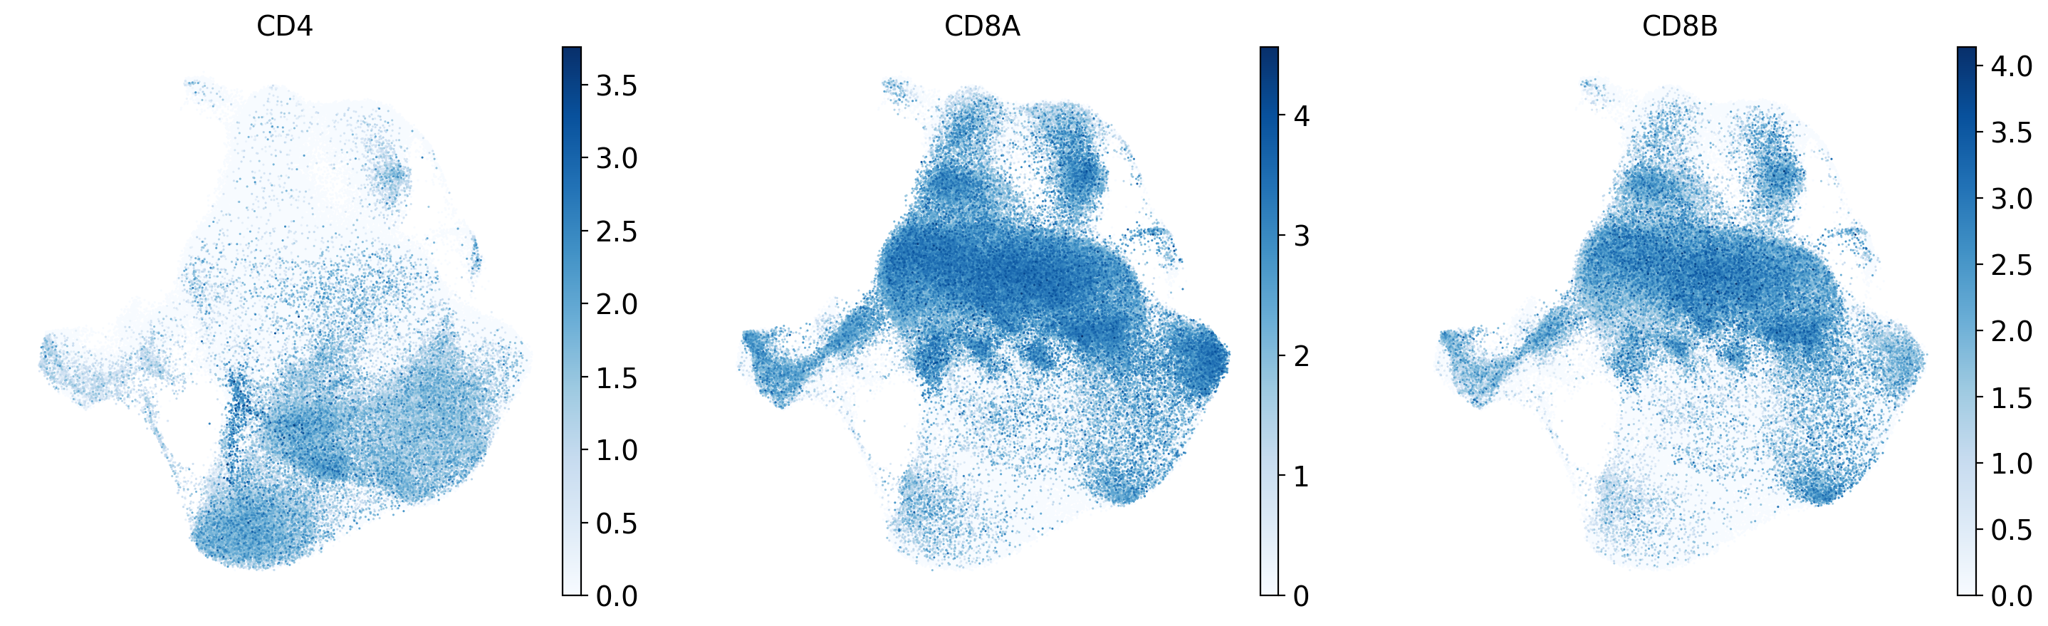

In [32]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata,
    color = ['CD4', 'CD8A', 'CD8B'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    color_map='Blues',
    ncols=3,
    size=5
)

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


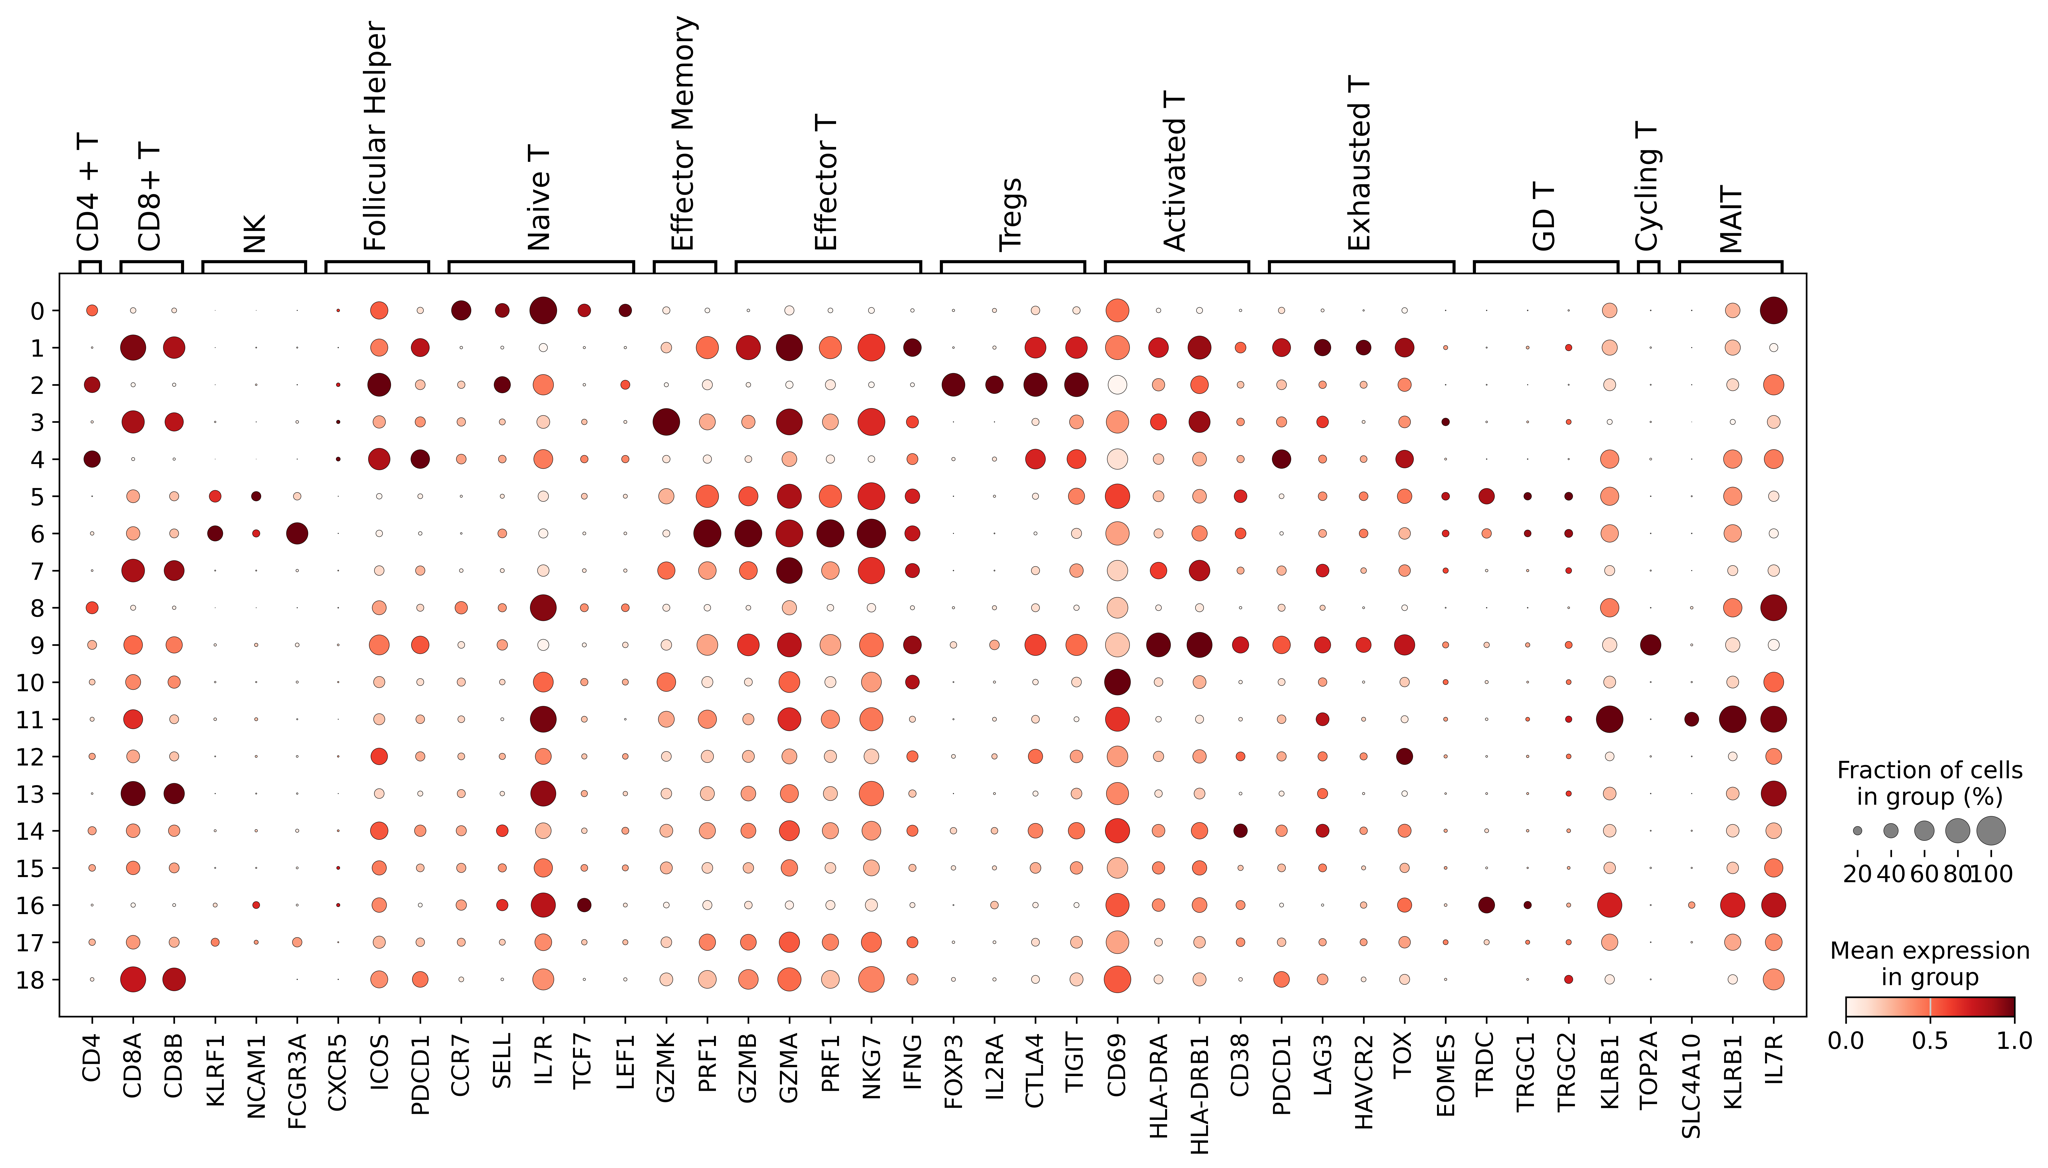

In [35]:

sc.settings.set_figure_params(dpi=300, dpi_save=300, figsize=(15,5), facecolor='white')

marker_dict = {
    'CD4 + T': ['CD4'],
    'CD8+ T': ['CD8A', 'CD8B'],
    'NK': ['KLRF1', 'NCAM1', 'FCGR3A'], #NCAM1 = CD56, FCGR3A = CD16
    'Follicular Helper': ['CXCR5', 'ICOS', 'PDCD1'],
    'Naive': ['CCR7', 'SELL',  'IL7R', 'TCF7', 'LEF1'],
    'Effector Memory': ['GZMK', 'PRF1'],
    'Effector T': [ 'GZMB', 'GZMA', 'PRF1', 'NKG7', 'IFNG'],
    'Tregs': ['FOXP3', 'IL2RA', 'CTLA4', 'TIGIT'],
    'Activated T' : ['CD69', 'HLA-DRA', 'HLA-DRB1', 'CD38'],
    'Exhausted T' : ['PDCD1', 'LAG3', 'HAVCR2', 'TOX', 'EOMES'],
    'GD T': ['TRDC', 'TRGC1', 'TRGC2', 'KLRB1'],
    'Cycling T': ['TOP2A'],
    'MAIT': ['SLC4A10', 'KLRB1', 'IL7R']
}


sc.pl.dotplot(
    adata, marker_dict, 'leiden',
    standard_scale='var', swap_axes=False
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

In [36]:
adata.obs.leiden.value_counts()

leiden
0     36469
1     33046
2     29141
3     28836
4     24159
5     22412
6     16650
7     12623
8     12360
9     12281
10    11094
11    11022
12    10304
13     7803
14     4855
15     3853
16     1956
17     1125
18      136
Name: count, dtype: int64

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


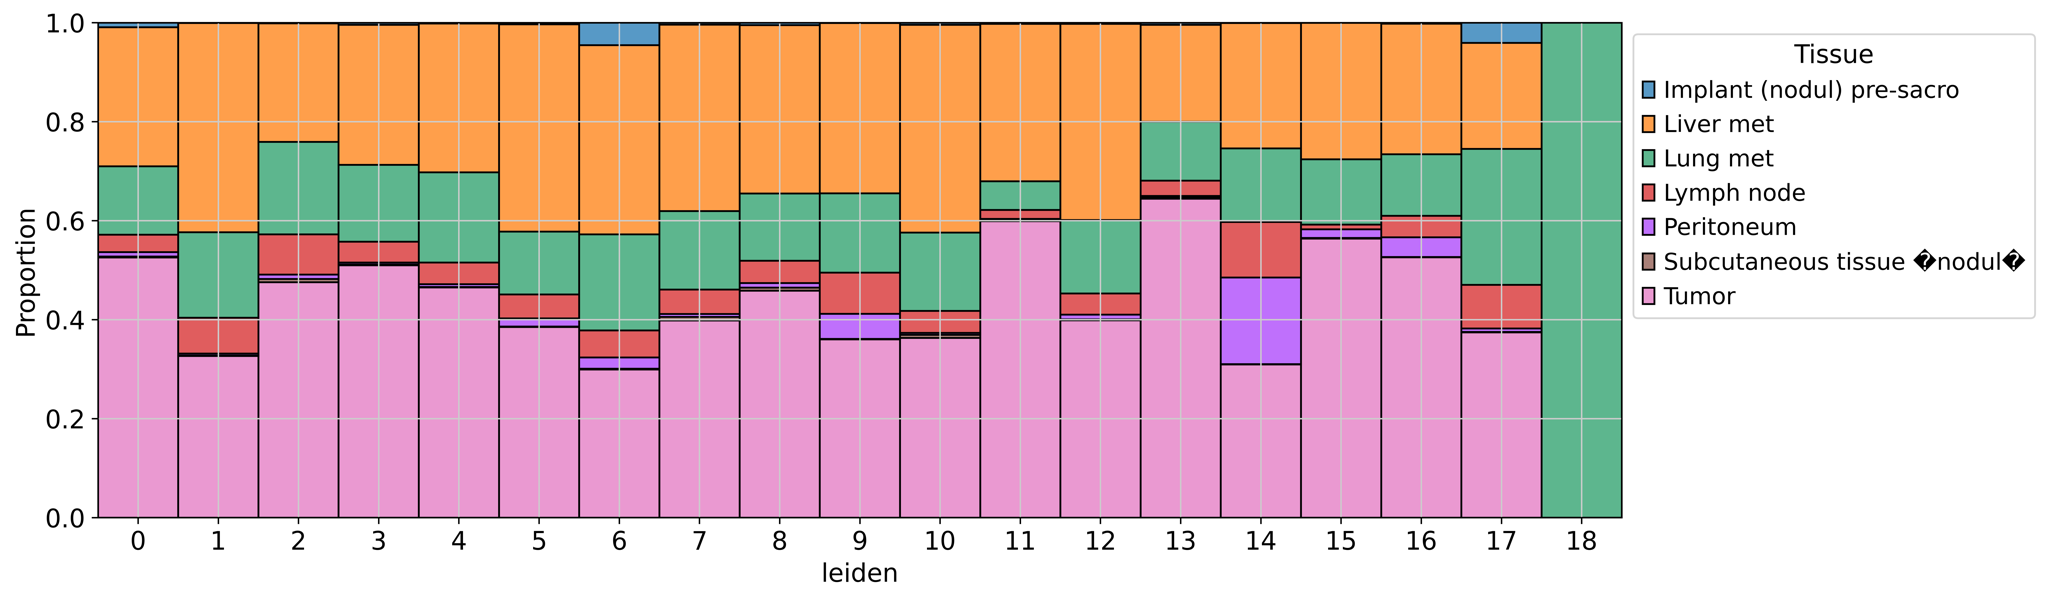

In [37]:
# stacked bar chart
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(15,5), facecolor='white')
ax = sns.histplot(
    data = integrated.obs,
    x = 'leiden',
    hue = 'Tissue',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


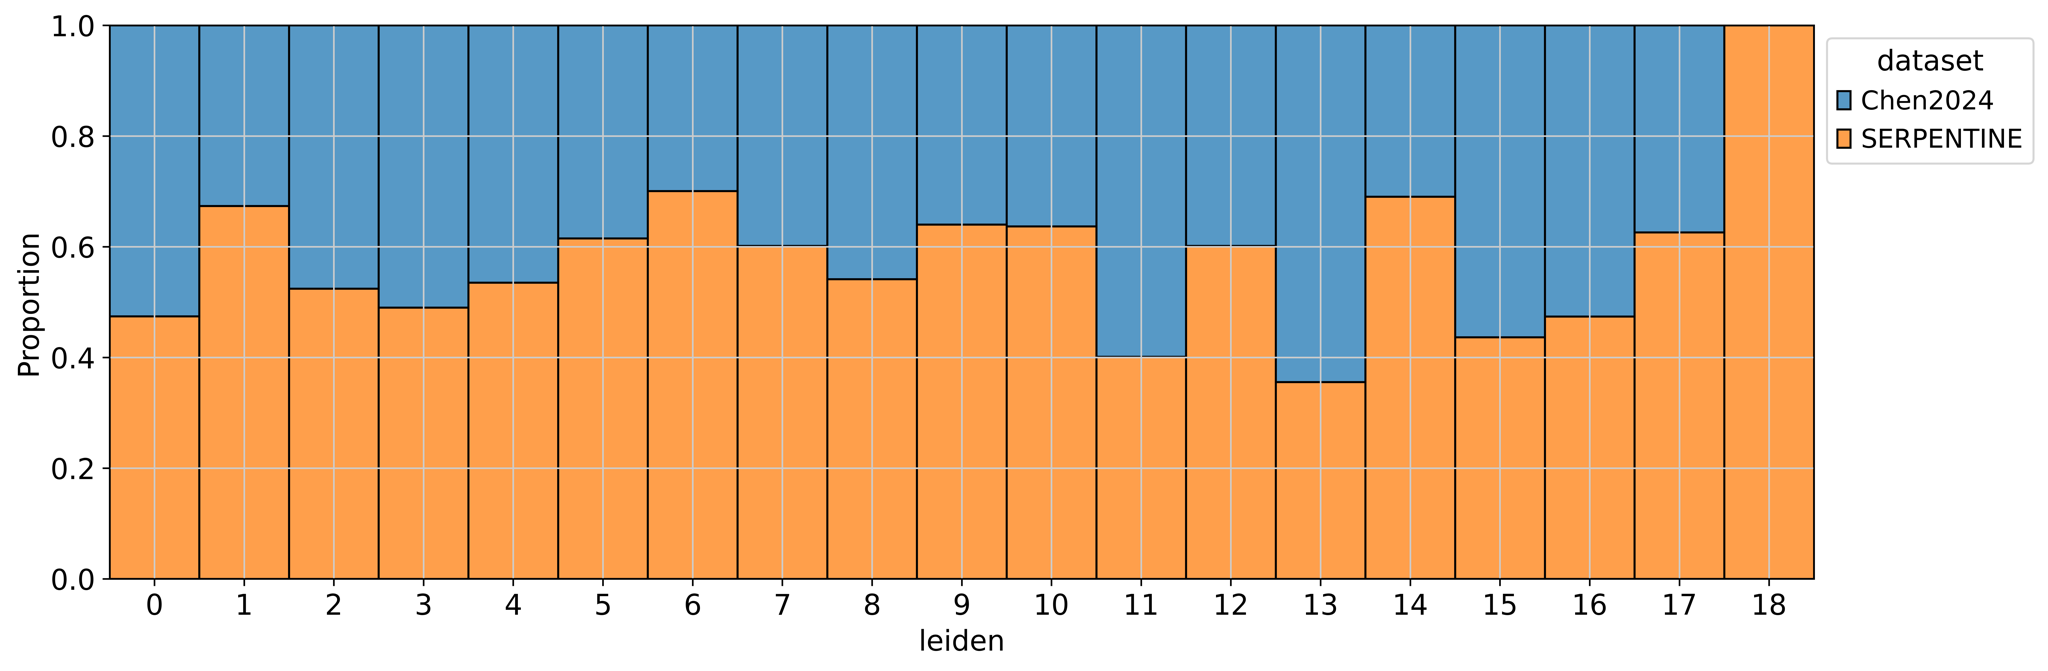

In [134]:
# stacked bar chart
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(15,5), facecolor='white')
ax = sns.histplot(
    data = integrated.obs,
    x = 'leiden',
    hue = 'dataset',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [135]:
integrated.obs.dataset.value_counts()

dataset
SERPENTINE    156759
Chen2024      123366
Name: count, dtype: int64

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

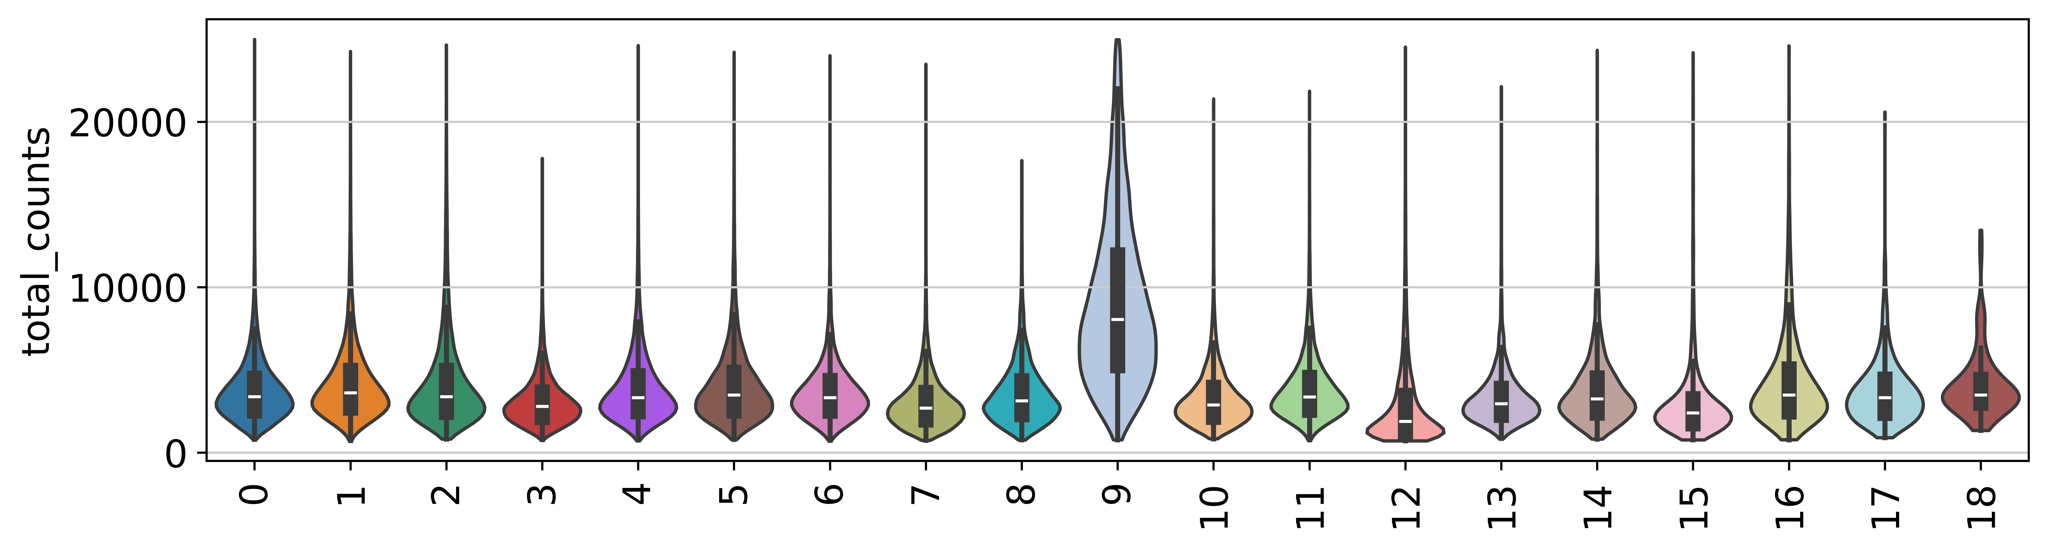

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

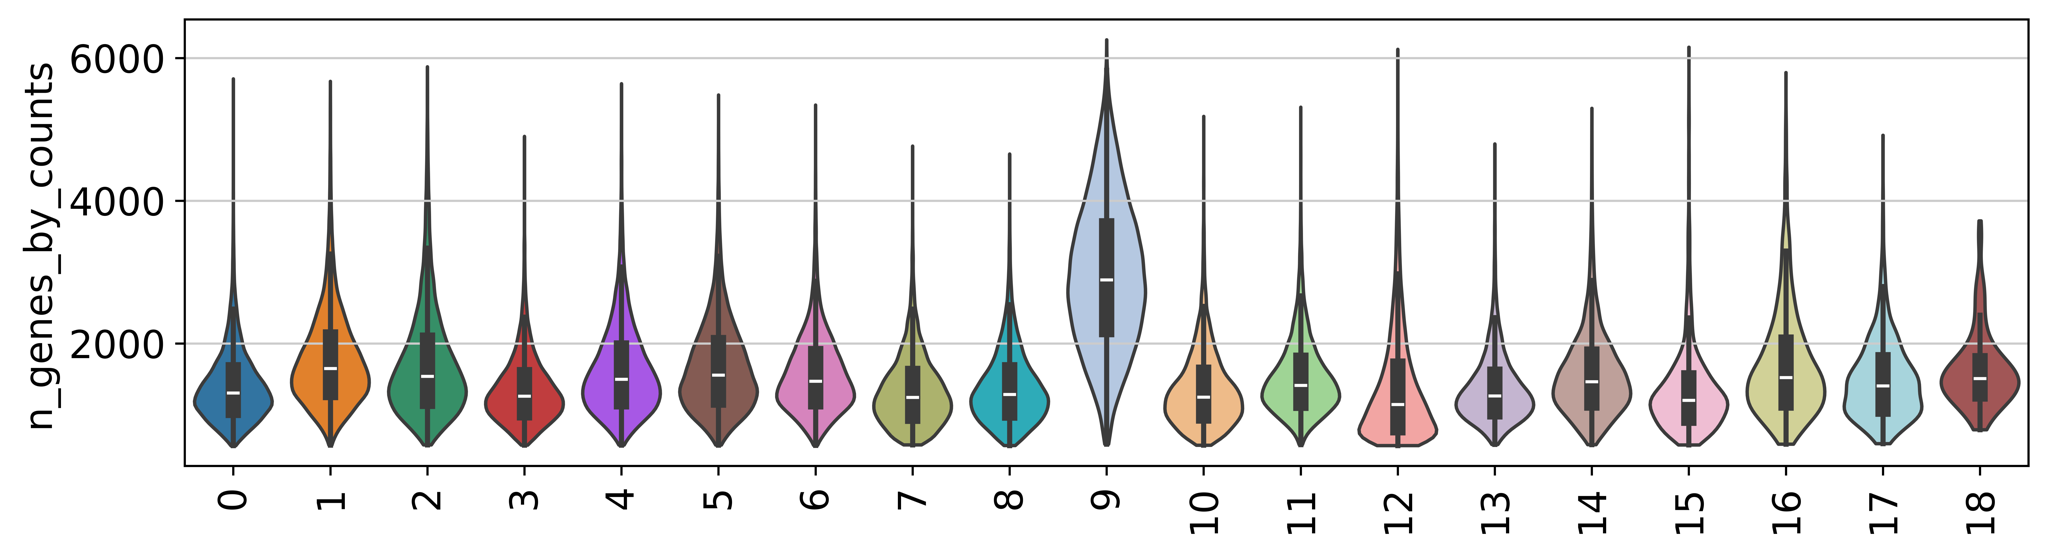

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

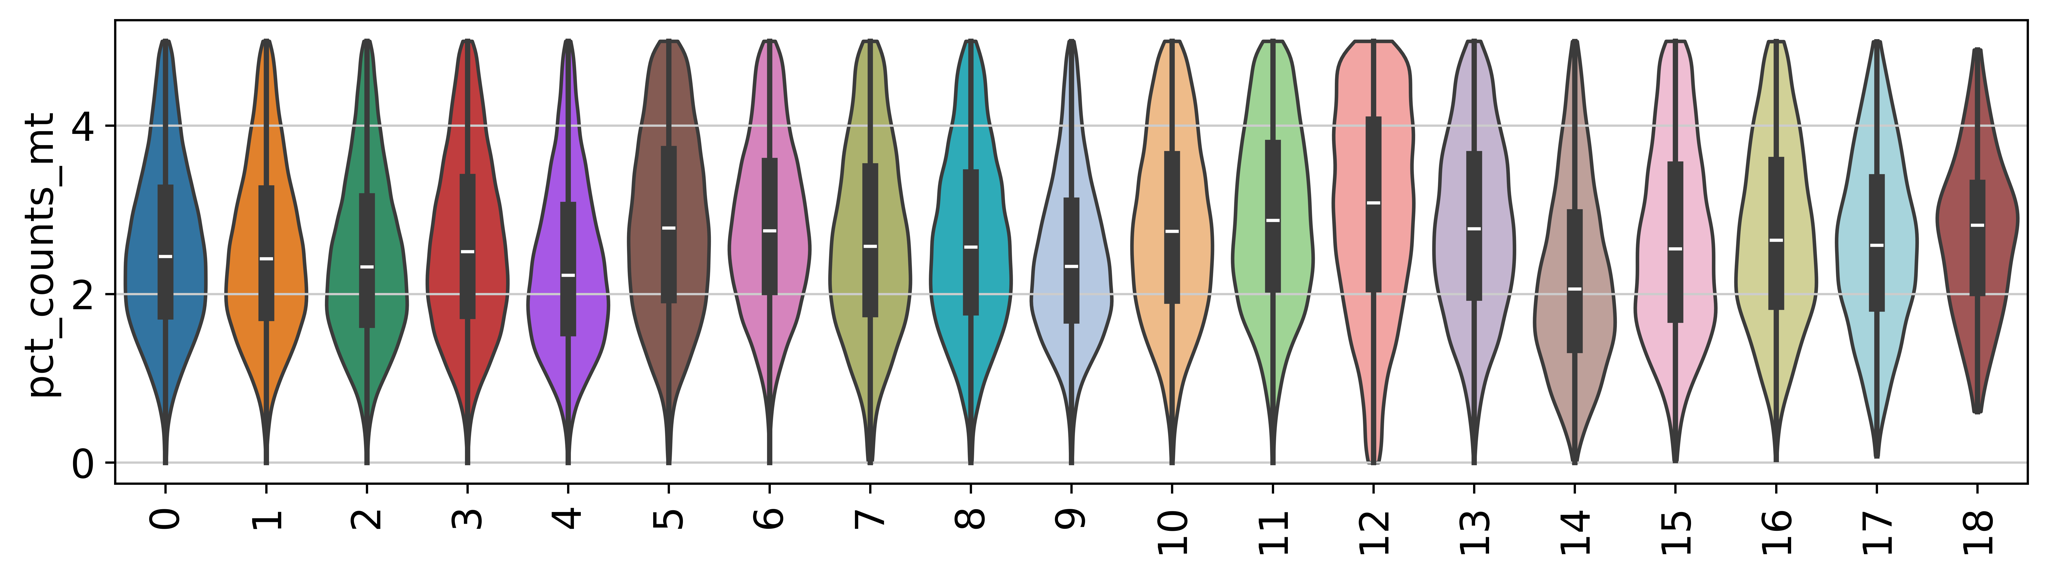

In [136]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')
sc.pl.violin(integrated,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(integrated,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(integrated,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)

## Evaluate performance of signal preservation

[Following this tutorial from CellANOVA.](https://github.com/Janezjz/cellanova/blob/main/tutorials/eval_signal_preservation.ipynb)


In [137]:
# no idea how long this will take to run
res = cnova.utils.calc_oobNN(
    integrated, 
    batch_key='Replicate', 
    condition_key='Timepoint'
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdou

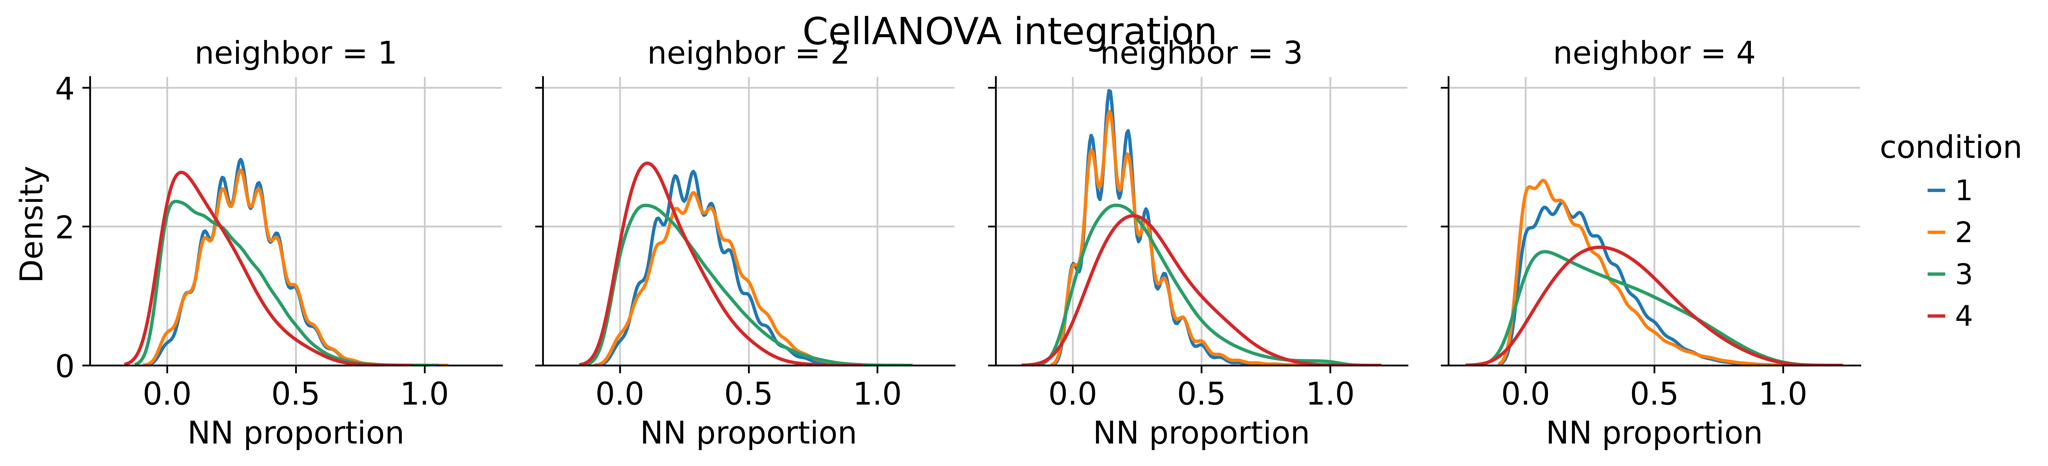

In [138]:
df = res.obsm['knn_prop']
df['condition'] = res.obs['Timepoint']
df = df.reset_index()
df = pd.melt(df, id_vars=['barcode', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'barcode': 'obs_name'})

g = sns.FacetGrid(df, col='neighbor', hue='condition')
g.map(sns.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('CellANOVA integration')
sns.set_style('white')
plt.show()

In [79]:
# no idea how long this will take to run
res = cnova.utils.calc_oobNN(
    integrated, 
    batch_key='Replicate', 
    condition_key='Tissue'
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdou

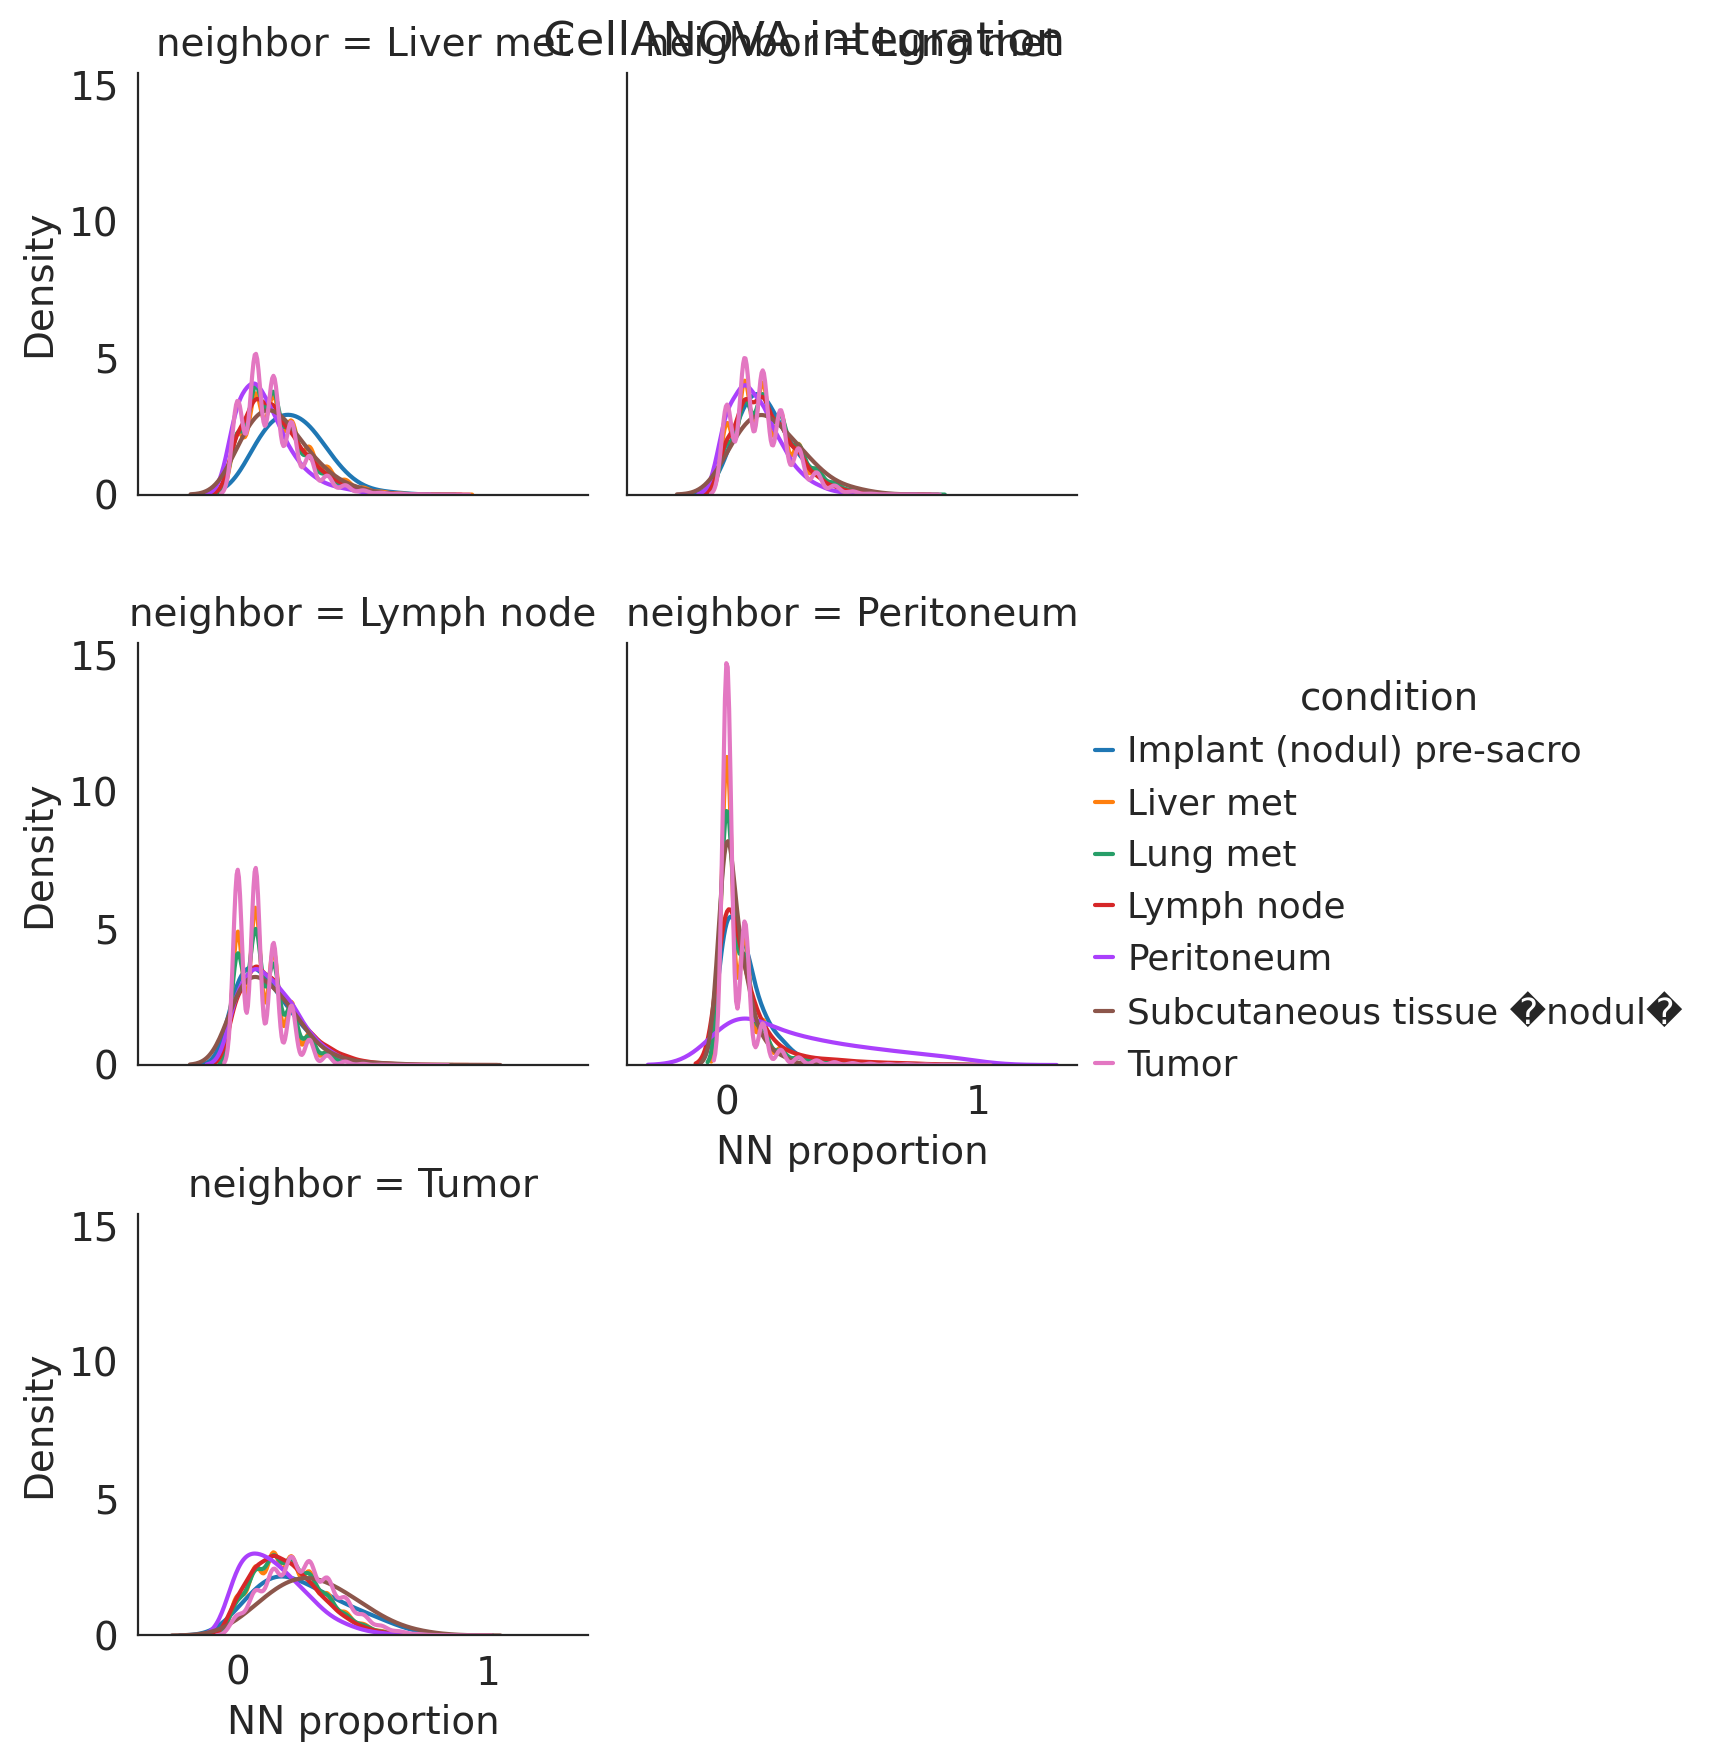

In [81]:
df = res.obsm['knn_prop']
df['condition'] = res.obs['Tissue']
df = df.reset_index()
df = pd.melt(df, id_vars=['barcode', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'barcode': 'obs_name'})

g = sns.FacetGrid(df, col='neighbor', hue='condition', col_wrap=2)
g.map(sns.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('CellANOVA integration')
sns.set_style('white')
plt.show()

## Marker genes

In [14]:
sc.tl.rank_genes_groups(integrated, groupby='leiden', method="wilcoxon")


In [15]:
group_key='leiden'

# get marker genes and add percent expressed
marker_genes_df = sc.get.rank_genes_groups_df(integrated, group=None)
markers = append_percent_expressed(adata, marker_genes_df, group_key, 0.5) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [43]:
filtered_markers = markers[
    (markers["pvals_adj"] <= p_thresh) &
    (markers["logfoldchanges"] >= lfc_thresh) &
    (markers["pct_in_group"] >= pct_in_thresh) & 
    (markers["pct_in_group"] > markers["pct_out_group"])
].sort_values(by='logfoldchanges', ascending=False).groupby('group')


In [47]:
markers.to_csv(
    "{}markers/CellANOVA_integrated_{}_subcluster_{}_markers.csv".format(data_dir, cur_name, 'leiden1'),
    index=False
)


# set the thresholds for plotting
p_thresh = 0.05 
lfc_thresh = 1.0
pct_in_thresh = 10

# Subset for p-value, log fold change, and percentage expression thresholds
filtered_markers = markers[
    (markers["pvals_adj"] <= p_thresh) &
    (markers["logfoldchanges"] >= lfc_thresh) &
    (markers["pct_in_group"] >= pct_in_thresh) 
    # (markers["pct_in_group"] > markers["pct_out_group"])
].sort_values(by='logfoldchanges', ascending=False).groupby('group').apply(lambda x: x) 

filtered_markers.to_csv(
    "{}/markers/CellANOVA_integrated_{}_subcluster_{}_markers_signif.csv".format(data_dir, cur_name, 'leiden1'),
    index=False
)



/scratch_tmp/33237089/ipykernel_95480/2950567494.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_markers = markers[


In [56]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,3), facecolor='white')

#-----------------------------------------------------------#
# make dotplots of the top 5 marker genes per cluster
#-----------------------------------------------------------#

cur_cluster = 'leiden_1'

# set the thresholds for plotting
p_thresh = 0.05 
lfc_thresh = 1.0
pct_in_thresh = 25
top_n = 5

# get the full list of marker genes
markers = pd.read_csv(
    "{}/markers/CellANOVA_integrated_{}_subcluster_{}_markers_signif.csv".format(data_dir, cur_name, 'leiden1'),
)
markers.group = markers.group.astype(str).astype('category')
markers.group = markers.group.cat.reorder_categories(adata.obs.leiden.cat.categories.to_list(), ordered=True)

# # Subset for p-value, log fold change, and percentage expression thresholds
# filtered_markers = markers[
#     (markers["pvals_adj"] < p_thresh) &
#     (markers["logfoldchanges"] > lfc_thresh) &
#     (markers["pct_in_group"] > pct_in_thresh)
# ]

# # Get the top N markers per group
# top_markers = (
#     filtered_markers
#     .groupby("group")
#     .apply(lambda x: x.sort_values(by="logfoldchanges", ascending=False).head(top_n))
# )
# top_markers = top_markers.reset_index(drop=True)

# # calculate marker genes for each of these clusters
# features = top_markers.groupby("group")["names"].apply(list).to_dict()

# sc.pl.dotplot(
#     anndata, features, cur_cluster,
#     standard_scale='var', swap_axes=False,
#     dendrogram=True,
#     save = '{}_integrated_subcluster_{}_top5markers.pdf'.format(cur_name, cur_cluster)
# )


ValueError: items in new_categories are not the same as in old categories

## Add CellANOVA results to the full Anndata

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


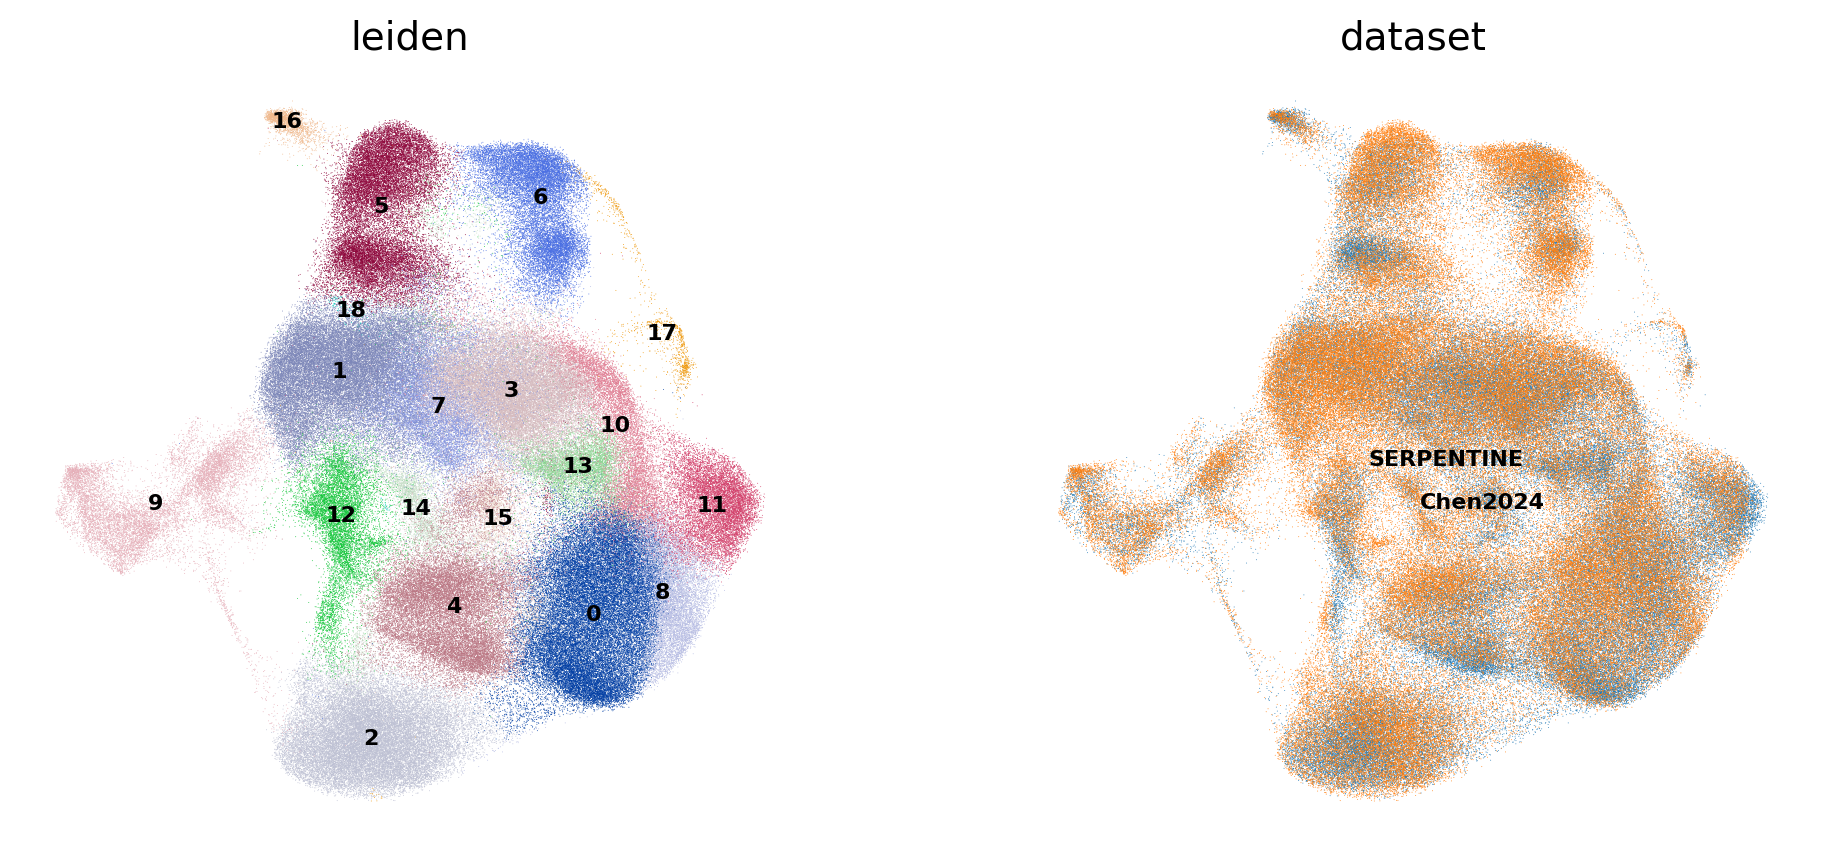

In [13]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata_full,
    color = ['leiden', 'dataset'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    ncols=2
)

## Benchmarking w/ scIB


TODO after performing the annotations

Honestly maybe I should make this a separate notebook? 


Compare PCA, Harmony, & CellANOVA + Harmony

In [ ]:
# from scib_metrics.benchmark import Benchmarker
# bm = Benchmarker(
#     adata,
#     batch_key="batch",
#     label_key="cell_type",
#     embedding_obsm_keys=[
#         "X_pca",
#         X_SCVI_KEY,
#         X_SCANVI_NO_FIX_KEY,
#         X_SCANVI_FIX_KEY,
#         X_SCANVI_FIX_LINEAR_KEY,
#     ],
#     n_jobs=-1,
# )
# bm.benchmark()